# MonReader

Importing necessary libraries.

In [89]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
    )
import seaborn as sns
from PIL import Image

#### Device Setup

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Function to lower the quality of picture while having same aspect ratio.

In [91]:
# Transforms (180x320)
transform = transforms.Compose([
    transforms.Resize((180, 320)),  # Resize to 1/6 of 1080x1920
    transforms.ToTensor(),
])

##### Load and label the data

In [92]:
train_dir = 'images/training'
test_dir = 'images/testing'

# This ImageFolder method of torch vision looks subfolders in the directory and label them automatically.
# It considers each subfolder as class.
# In this case, it will consider flip/notflip folders as classes and assign 1/0 labels automatically.
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# Shuffles the data.
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

# Check label mappings
print("Class to index mapping:", train_data.class_to_idx)

Class to index mapping: {'flip': 0, 'notflip': 1}


#### Visualize sample batch

<Figure size 800x1600 with 0 Axes>

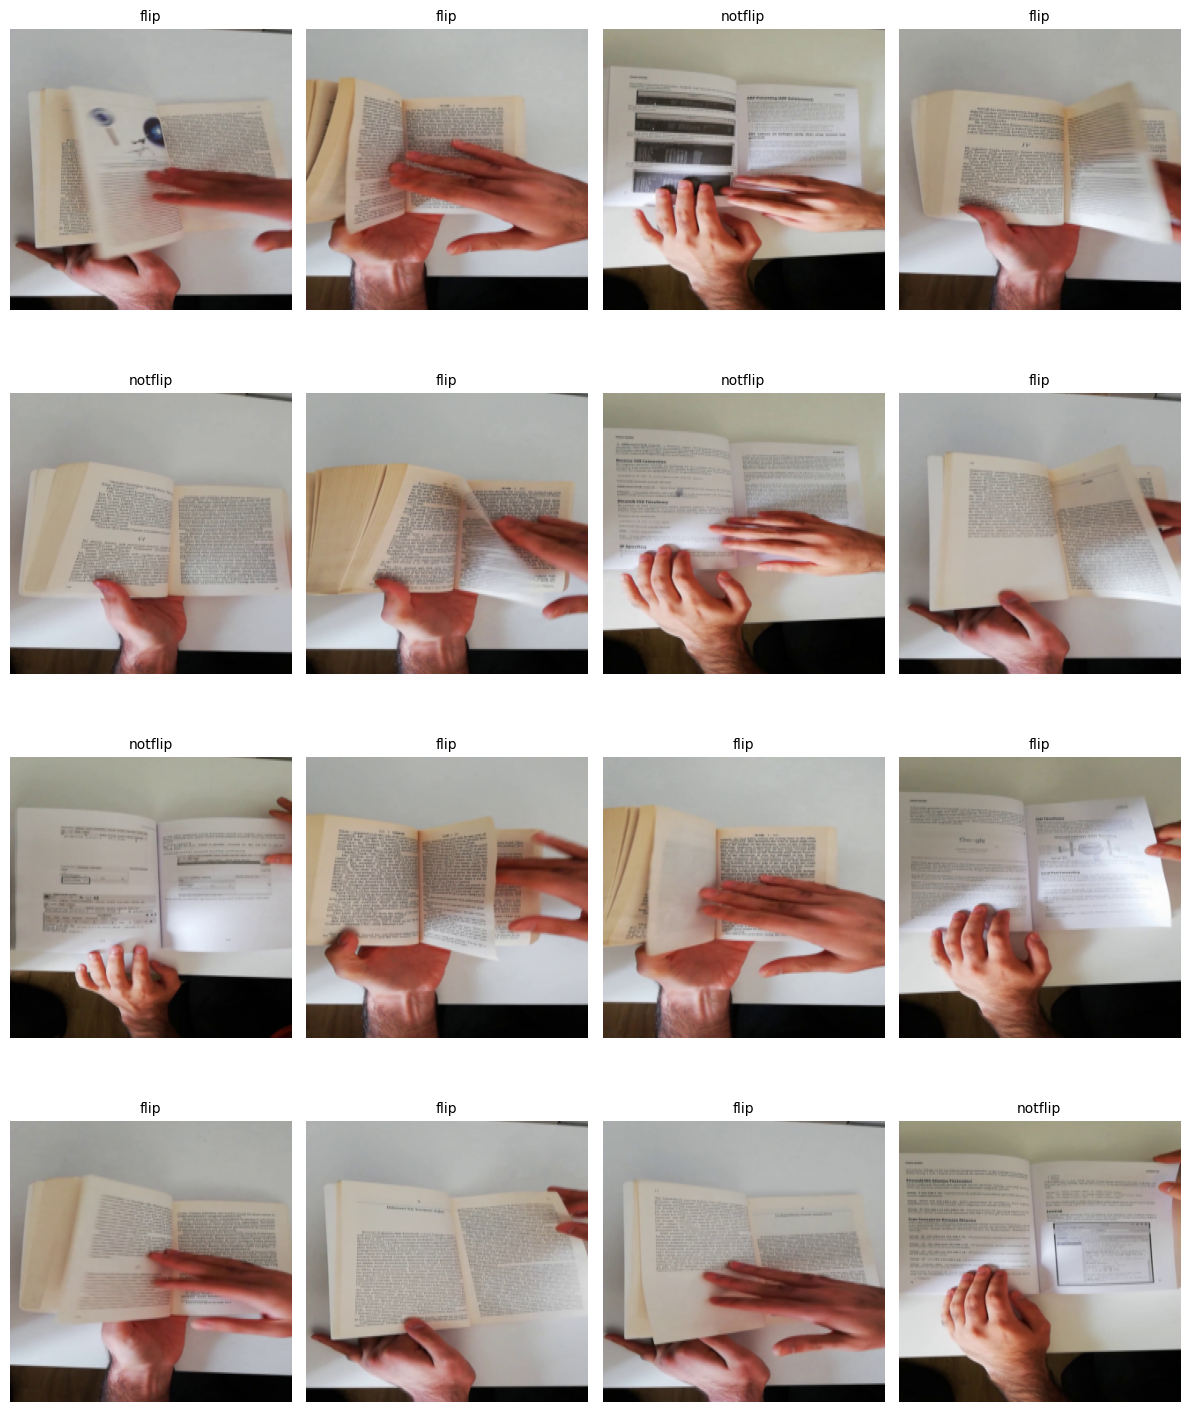

In [93]:
def show_batch(data_loader, class_names):

    images, labels = next(iter(data_loader))
    images = images[:16]  # Limit to 16 images
    labels = labels[:16]

    num_images = len(images)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Auto-adjust number of rows

    plt.figure(figsize=(cols * 2, rows * 4))  # Make each subplot tall for portrait

    plt.figure(figsize=(12, 15))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)  # 4x4 grid
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(class_names[labels[i]], fontsize=10)
        plt.axis('off')
        plt.gca().set_aspect(640 / 360)  # Keep portrait aspect ratio

    plt.tight_layout()
    plt.show()

# Call it
show_batch(train_loader, train_data.classes)

#### PyTorch CNN Model

In [94]:
class FlipDetectorCNN(nn.Module):
    def __init__(self):
        super(FlipDetectorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # (8, 90, 160)
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # (16, 45, 80)
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # (32, 22, 40)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 22 * 40, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


#### Initialize Model, Loss, Optimizer

In [95]:
model = FlipDetectorCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#### Training

In [96]:
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    print(f"\nEpoch {epoch+1}/{epochs}")
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

    for batch_idx, (images, labels) in loop:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Batch {batch_idx+1}/{len(train_loader)}")
        loop.set_postfix(loss=loss.item())

    end_time = time.time()
    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} completed in {end_time - start_time:.2f} seconds. Avg Loss: {avg_loss:.4f}")



Epoch 1/15


✅ Epoch 1 completed in 166.65 seconds. Avg Loss: 0.6845

Epoch 2/15


✅ Epoch 2 completed in 168.02 seconds. Avg Loss: 0.5996

Epoch 3/15


✅ Epoch 3 completed in 165.38 seconds. Avg Loss: 0.4359

Epoch 4/15


✅ Epoch 4 completed in 161.05 seconds. Avg Loss: 0.3105

Epoch 5/15


✅ Epoch 5 completed in 161.60 seconds. Avg Loss: 0.2496

Epoch 6/15


✅ Epoch 6 completed in 162.61 seconds. Avg Loss: 0.2108

Epoch 7/15


✅ Epoch 7 completed in 154.74 seconds. Avg Loss: 0.1813

Epoch 8/15


✅ Epoch 8 completed in 161.37 seconds. Avg Loss: 0.1560

Epoch 9/15


✅ Epoch 9 completed in 164.47 seconds. Avg Loss: 0.1511

Epoch 10/15


✅ Epoch 10 completed in 167.40 seconds. Avg Loss: 0.1245

Epoch 11/15


✅ Epoch 11 completed in 170.20 seconds. Avg Loss: 0.1135

Epoch 12/15


✅ Epoch 12 completed in 167.38 seconds. Avg Loss: 0.1129

Epoch 13/15


✅ Epoch 13 completed in 168.89 seconds. Avg Loss: 0.0928

Epoch 14/15


✅ Epoch 14 completed in 169.64 seconds. Avg Loss: 0.0949

Epoch 15/15


✅ Epoch 15 completed in 167.05 seconds. Avg Loss: 0.0714


#### Evaluation on Test Set

In [97]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).int()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds)
print(f"\nF1 Score on Test Set: {f1:.4f}")



F1 Score on Test Set: 0.9549



📊 Evaluation Metrics:
✅ Accuracy:  0.9548
✅ Precision: 0.9795
✅ Recall:    0.9316
✅ F1 Score:  0.9549

📋 Classification Report:
              precision    recall  f1-score   support

        flip       0.93      0.98      0.95       290
     notflip       0.98      0.93      0.95       307

    accuracy                           0.95       597
   macro avg       0.96      0.96      0.95       597
weighted avg       0.96      0.95      0.95       597



C:\Users\hayee\AppData\Local\Temp\ipykernel_26296\2997277421.py:30: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
g:\MonReader\.conda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


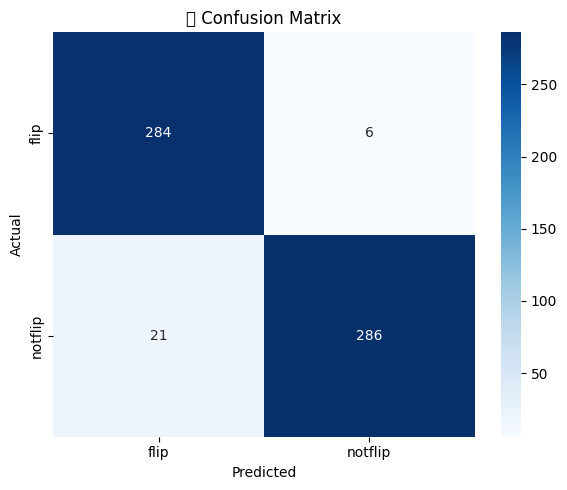

In [98]:

# Convert to arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)

conf_matrix = confusion_matrix(all_labels, all_preds)

# Print metrics
print("\n📊 Evaluation Metrics:")
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('🧾 Confusion Matrix')
plt.tight_layout()
plt.show()

#### Test on single Image.

##### Test 1/2

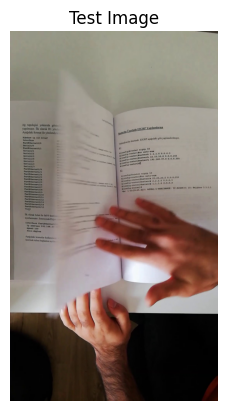

In [148]:
# Path to image
image_path = 'realtimetest/FlipSingleImage/001.jpg' 
# Load and transform
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)
# Show image
plt.imshow(img)
plt.title("Test Image")
plt.axis('off')
plt.show()

Image is actually showing a page is being flipped.

##### Model output for above image.

In [149]:
# Model prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prediction = (output > 0.5).item()

# Output result
class_names = train_data.classes  # ['flip', 'notflip']

predicted_class = class_names[int(prediction)]
print(f" Model Prediction: {predicted_class.upper()}")

 Model Prediction: FLIP


##### Test 2/2

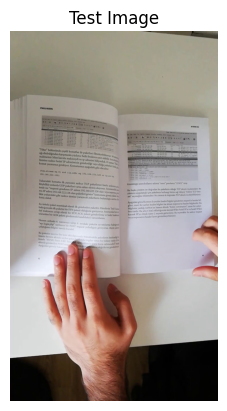

In [150]:
# Path to image
image_path2 = 'realtimetest/NotFlipSingleImage/001.jpg' 
# Load and transform
img2 = Image.open(image_path2).convert('RGB')
input_tensor2 = transform(img2).unsqueeze(0).to(device)
# Show image
plt.imshow(img2)
plt.title("Test Image")
plt.axis('off')
plt.show()

Image is actually showing a page is NOT being flipped.

##### Model output for above image.

In [151]:
# Model prediction
model.eval()
with torch.no_grad():
    output2 = model(input_tensor2)
    prediction2 = (output2 > 0.5).item()

# Output result
class_names2 = train_data.classes  # ['flip', 'notflip']

predicted_class2 = class_names[int(prediction2)]
print(f" Model Prediction: {predicted_class2.upper()}")

 Model Prediction: NOTFLIP


##### Detecting a flip in sequence

Sequence actually contains page flipping images

In [155]:
# Directory with 9 sequential images
sequence_dir = 'realtimetest/FlipSequence/' 

# Sort image filenames to maintain order
image_files = sorted([f for f in os.listdir(sequence_dir) if f.endswith(('.jpg', '.png'))])[:9]

sequence_predictions = []

for file in image_files:
    img_path = os.path.join(sequence_dir, file)
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        pred = (output > 0.5).item()
        sequence_predictions.append(int(pred))

flip_detect = 'FLIP DETECTED' if 0 in sequence_predictions else 'NO FLIP DETECTED'

print(f"\n Sequence Results: {sequence_predictions}")
print(f" Final Prediction on Sequence: {flip_detect}")



 Sequence Results: [1, 1, 1, 1, 0, 1, 0, 0, 0]
 Final Prediction on Sequence: FLIP DETECTED


Following sequence is actually a not flipping pages image sequence.

In [156]:
# Directory with 9 sequential images
sequence_dir = 'realtimetest/NotFlipSequence/' 

# Sort image filenames to maintain order
image_files = sorted([f for f in os.listdir(sequence_dir) if f.endswith(('.jpg', '.png'))])[:9]

sequence_predictions = []

for file in image_files:
    img_path = os.path.join(sequence_dir, file)
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        pred = (output > 0.5).item()
        sequence_predictions.append(int(pred))

# Majority vote
flip_detect = 'FLIP DETECTED' if 0 in sequence_predictions else 'NO FLIP DETECTED'

print(f"\n Sequence Results: {sequence_predictions}")
print(f" Final Prediction on Sequence: {flip_detect}")


 Sequence Results: [1, 1, 1, 1, 1, 1, 1, 1, 1]
 Final Prediction on Sequence: NO FLIP DETECTED


### Save Model

In [ ]:
torch.save(model.state_dict(), "flip_detector_cnn.pth")